# Notebook to run Annotation Human Heart to Mouse Heart - Myeloid

**Created by** : Srivalli Kolla

**Created on** : 2 October, 2024

**Modified on** : 3 October, 2024

**Institute of Systems Immunology, University of Würzburg**

Env : scvi-env

# Import Packages

In [1]:
import scvi
import torch
import anndata
import warnings
import time
import datetime
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
import scib_metrics
import scib
import faiss
import matplotlib.pyplot as plt

from scib_metrics.nearest_neighbors import NeighborsResults
from pywaffle import Waffle
from scib_metrics.benchmark import Benchmarker, BioConservation

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.10.8
scanpy      1.10.2
-----
Cython              3.0.11
PIL                 10.3.0
absl                NA
asttokens           NA
attr                23.2.0
chex                0.1.86
colorama            0.4.6
comm                0.2.2
contextlib2         NA
cycler              0.12.1
cython              3.0.11
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
deprecated          1.2.14
django              5.0.6
docrep              0.3.2
etils               1.9.2
executing           2.0.1
faiss               1.8.0
filelock            3.15.4
flax                0.8.5
fsspec              2024.6.1
h5py                3.11.0
igraph              0.11.6
importlib_resources NA
ipykernel           6.29.5
ipywidgets          8.1.5
jax                 0.4.30
jaxlib              0.4.30
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
lightnin

/home/skolla/miniforge3/envs/scvi-env/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/home/skolla/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.


In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

# Import Data

## Reference

In [5]:
ref_all = sc.read_h5ad('../../data/Global_raw.h5ad')
ref_all

AnnData object with n_obs × n_vars = 704296 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_t

In [6]:
ref_all.obs['region_finest'].value_counts()

region_finest
LV                   130304
AX                   102221
RV                    92403
SP                    88911
LA                    74501
RA                    55060
SAN                   31227
AVN                   28024
na                    23769
AVN SEPT LAT          11753
IVS MID LV             8995
LV FW ANTLAT ENDO      8274
RV FW ENDO             7949
SAN CAUD CRAN          5519
LV APEX ENDO           4905
AVN MID LAT            4844
RV FW EPI              4102
LV FW ANTLAT EPI       4039
SAN CRAN CAUD          3560
SAN MID CAUD           3482
RAA                    2435
AVN SEPT SEPT          1786
AVN LAT SEPT           1567
IVS MID RV             1118
AVN MID SEPT           1045
SAN MID CRAN           1011
LV APEX EPI             907
SAN MID                 585
Name: count, dtype: int64

In [7]:
ref_all.obs['cell_or_nuclei'].value_counts()

cell_or_nuclei
Nuclei    568598
Cell      135698
Name: count, dtype: int64

In [8]:
ref_all.obs['cell_type'].value_counts()

cell_type
Ventricular Cardiomyocyte     190710
Fibroblast                    138055
Endothelial cell              131505
Mural cell                    104593
Myeloid                        51426
Atrial Cardiomyocyte           45911
Lymphoid                       24922
Neural cell                     6622
Adipocyte                       6347
Mast cell                       1853
Lymphatic Endothelial cell      1295
Mesothelial cell                1057
Name: count, dtype: int64

### Subsetting data

In [9]:
ref = ref_all[(ref_all.obs['region_finest'] == 'LV') & (ref_all.obs['cell_type'] == 'Myeloid') & (ref_all.obs['cell_or_nuclei'] == 'Nuclei')]
ref

View of AnnData object with n_obs × n_vars = 3609 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'd

In [10]:
ref.obs['cell_state'].value_counts()

cell_state
LYVE1+IGF1+MP       2122
unclassified         368
MoMP                 306
LYVE1+MP_cycling     237
LYVE1+TIMD4+MP       199
CD16+Mo              141
DC                   128
CD14+Mo              108
Name: count, dtype: int64

In [11]:
ref.obs['region_finest'].value_counts()

region_finest
LV    3609
Name: count, dtype: int64

In [12]:
ref.obs['cell_or_nuclei'].value_counts()

cell_or_nuclei
Nuclei    3609
Name: count, dtype: int64

In [13]:
ref = ref[ref.obs['cell_state'] != 'unclassified']
ref

View of AnnData object with n_obs × n_vars = 3241 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'd

In [14]:
ref.obs['cell_state'].value_counts()

cell_state
LYVE1+IGF1+MP       2122
MoMP                 306
LYVE1+MP_cycling     237
LYVE1+TIMD4+MP       199
CD16+Mo              141
DC                   128
CD14+Mo              108
Name: count, dtype: int64

In [15]:
ref.obs['sample'] = ref.obs['donor'].copy()

In [16]:
ref.obs['seed_labels'] = ref.obs['cell_state'].copy()
ref.obs['seed_labels'].value_counts()
ref.obs['seed_labels'].cat.categories

Index(['CD14+Mo', 'CD16+Mo', 'MoMP', 'LYVE1+IGF1+MP', 'LYVE1+TIMD4+MP',
       'LYVE1+MP_cycling', 'DC'],
      dtype='object')

In [17]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [18]:
print(X_is_raw(ref))

True


In [19]:
ref.layers['raw_counts'] = ref.X
ref

AnnData object with n_obs × n_vars = 3241 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', '

In [20]:
sc.pp.filter_cells(ref, min_genes = 200)
sc.pp.filter_cells(ref, min_counts = 100)
ref

AnnData object with n_obs × n_vars = 3241 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', '

## Query

In [21]:
query_all = sc.read_h5ad('../../data/dmd_heart_after_cb_qc_batch_correction_02_10_2024.h5ad')
query_all

AnnData object with n_obs × n_vars = 124921 × 8000
    obs: 'sample', 'genotype', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'gender_check_cov_colors', 'genotype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'predicted_doublets_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized', 'raw_counts'
    obsp: 'connectivities', 'distances'

### Subsetting data

In [22]:
query = query_all[query_all.obs['genotype'] == 'WT']
query

View of AnnData object with n_obs × n_vars = 61606 × 8000
    obs: 'sample', 'genotype', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'gender_check_cov_colors', 'genotype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'predicted_doublets_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [23]:
query.obs['seed_labels'] = 'Unknown'

In [24]:
print (X_is_raw(query))

False


In [25]:
query.X = query.layers['raw_counts']

In [26]:
print (X_is_raw(query))

True


In [27]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)
query

filtered out 39079 cells that have less than 200 genes expressed


AnnData object with n_obs × n_vars = 22527 × 8000
    obs: 'sample', 'genotype', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'seed_labels', 'n_genes', 'n_counts'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'gender_check_cov_colors', 'genotype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'predicted_doublets_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized', 'raw_counts'
    obsp: 'connectivities', 'distances'

### Checking vars

In [28]:
ref.var

gene_name-new gene_name_scRNA-0-original  \
ENSG00000243485   MIR1302-2HG                MIR1302-2HG   
ENSG00000237613       FAM138A                    FAM138A   
ENSG00000186092         OR4F5                      OR4F5   
ENSG00000238009    AL627309.1                 AL627309.1   
ENSG00000239945    AL627309.3                 AL627309.3   
...                       ...                        ...   
ENSG00000277856    AC233755.2                 AC233755.2   
ENSG00000275063    AC233755.1                 AC233755.1   
ENSG00000271254    AC240274.1                 AC240274.1   
ENSG00000277475    AC213203.2                 AC213203.1   
ENSG00000268674    AC213203.1                    FAM231C   

                gene_name_snRNA-1-original gene_name_multiome-2-original  
ENSG00000243485                MIR1302-2HG                   MIR1302-2HG  
ENSG00000237613                    FAM138A                       FAM138A  
ENSG00000186092                      OR4F5                         OR4F5  
ENSG00000238009                 AL627309.1                    AL627309.1  
ENSG00000239945                 AL627309.3                    AL627309.3  
...                                    ...                           ...  
ENSG00000277856                 AC233755.2                    AC233755.2  
ENSG00000275063                 AC233755.1                    AC233755.1  
ENSG00000271254                 AC240274.1                    AC240274.1  
ENSG00000277475                 AC213203.1                    AC213203.2  
ENSG00000268674                    FAM231C                    AC213203.1  

[32732 rows x 4 columns]

In [29]:
ref.var.index = ref.var['gene_name_snRNA-1-original'].values.copy().astype(object)
ref.var

gene_name-new gene_name_scRNA-0-original  \
MIR1302-2HG   MIR1302-2HG                MIR1302-2HG   
FAM138A           FAM138A                    FAM138A   
OR4F5               OR4F5                      OR4F5   
AL627309.1     AL627309.1                 AL627309.1   
AL627309.3     AL627309.3                 AL627309.3   
...                   ...                        ...   
AC233755.2     AC233755.2                 AC233755.2   
AC233755.1     AC233755.1                 AC233755.1   
AC240274.1     AC240274.1                 AC240274.1   
AC213203.1     AC213203.2                 AC213203.1   
FAM231C        AC213203.1                    FAM231C   

            gene_name_snRNA-1-original gene_name_multiome-2-original  
MIR1302-2HG                MIR1302-2HG                   MIR1302-2HG  
FAM138A                        FAM138A                       FAM138A  
OR4F5                            OR4F5                         OR4F5  
AL627309.1                  AL627309.1                    AL627309.1  
AL627309.3                  AL627309.3                    AL627309.3  
...                                ...                           ...  
AC233755.2                  AC233755.2                    AC233755.2  
AC233755.1                  AC233755.1                    AC233755.1  
AC240274.1                  AC240274.1                    AC240274.1  
AC213203.1                  AC213203.1                    AC213203.2  
FAM231C                        FAM231C                    AC213203.1  

[32732 rows x 4 columns]

In [30]:
query.var

mt   ribo  n_cells_by_counts  mean_counts  \
Xkr4        False  False               2530     0.043516   
Gm1992      False  False                300     0.002071   
Gm37381     False  False                 72     0.000600   
Rp1         False  False                892     0.009895   
Sox17       False  False               3921     0.027996   
...           ...    ...                ...          ...   
mt-Nd6       True  False              47095     0.347786   
mt-Cytb      True  False             166200     7.409929   
Tmlhe       False  False              10798     0.088477   
Gm10931     False  False                 80     0.000446   
AC149090.1  False  False              15062     0.126709   

            pct_dropout_by_counts  total_counts  highly_variable  \
Xkr4                    98.656214          8193             True   
Gm1992                  99.840658           390             True   
Gm37381                 99.961758           113             True   
Rp1                     99.526222          1863             True   
Sox17                   97.917397          5271             True   
...                           ...           ...              ...   
mt-Nd6                  74.985925         65479             True   
mt-Cytb                 11.724402       1395097             True   
Tmlhe                   94.264742         16658             True   
Gm10931                 99.957509            84             True   
AC149090.1              91.999958         23856             True   

            highly_variable_rank     means  variances  variances_norm  \
Xkr4                       255.0  0.060342   0.373288        3.306751   
Gm1992                    3395.0  0.002858   0.004531        1.306889   
Gm37381                   1657.0  0.000688   0.001328        1.440361   
Rp1                        588.5  0.010543   0.036512        2.396970   
Sox17                     3843.0  0.039417   0.067370        1.159135   
...                          ...       ...        ...             ...   
mt-Nd6                    2040.0  0.420674   0.628211        0.982251   
mt-Cytb                   2067.0  7.984606  37.546537        0.930745   
Tmlhe                     3118.0  0.117610   0.218492        0.971496   
Gm10931                   3862.5  0.000608   0.000672        0.985000   
AC149090.1                1333.0  0.177000   0.364500        0.921006   

            highly_variable_nbatches  
Xkr4                               6  
Gm1992                             6  
Gm37381                            5  
Rp1                                6  
Sox17                              5  
...                              ...  
mt-Nd6                             3  
mt-Cytb                            3  
Tmlhe                              1  
Gm10931                            2  
AC149090.1                         1  

[8000 rows x 12 columns]

In [31]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'SOX17', 'RGS20', 'ALKAL1', 'ST18',
       'SNTG1', '2610203C22RIK',
       ...
       'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYTB',
       'TMLHE', 'GM10931', 'AC149090.1'],
      dtype='object', length=8000)

In [32]:
ref.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=32732)

In [33]:
unique_var = ~ref.var.index.duplicated(keep='first')
ref = ref[:, unique_var]

# Data concatenation

#### Checking for duplicates

In [34]:
adata = ref.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 25768 × 5226
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'mt-query', 'ribo-query', 'n_cells_by_counts

In [35]:
adata.obs['seed_labels'].value_counts()

seed_labels
Unknown             22527
LYVE1+IGF1+MP        2122
MoMP                  306
LYVE1+MP_cycling      237
LYVE1+TIMD4+MP        199
CD16+Mo               141
DC                    128
CD14+Mo               108
Name: count, dtype: int64

In [36]:
adata.obs['sample'].value_counts()

sample
A10_2    19274
A9_2      3253
D7         669
D3         645
D2         357
D8         322
D5         230
H7         209
H2         170
H4         130
H3         113
H6          99
H5          94
D4          78
D1          69
D6          39
D11         17
Name: count, dtype: int64

In [37]:
adata.obs['batch'].value_counts()

batch
query        22527
reference     3241
Name: count, dtype: int64

In [38]:
adata.obs['region_finest'].value_counts()

region_finest
LV    3241
Name: count, dtype: int64

In [39]:
adata.obs['cell_or_nuclei'].value_counts()

cell_or_nuclei
Nuclei    3241
Name: count, dtype: int64

In [40]:
print(X_is_raw(adata))

True


In [41]:
adata_raw = adata.copy()

In [42]:
adata.layers['raw_counts'] = adata.X.copy()

In [43]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "raw_counts",
    batch_key = "sample", span = 1, subset= True)

adata

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 25768 × 5226
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'mt-query', 'ribo-query', 'n_cells_by_counts

# SCVI

In [44]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'sample', 
                              labels_key = 'seed_labels',
                              layer = 'raw_counts',
                              categorical_covariate_keys = ['sample', 'batch'])
adata

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


AnnData object with n_obs × n_vars = 25768 × 5226
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'mt-query', 'ribo-query', 'n_cells_by_counts

In [45]:
model_scvi = scvi.model.SCVI(adata, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [46]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'raw_counts',
│   'batch_key': 'sample',
│   'labels_key': 'seed_labels',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample', 'batch'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  17   │
│         n_cells          │ 25768 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   8   │
│          n_vars          │ 5226  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │         adata.layers['raw_counts']         │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    A9_2    │          0          │
│                     │   A10_2    │          1          │
│                     │     D1     │          2          │
│                     │     D2     │          3          │
│                     │     D3     │          4          │
│                     │     D4     │          5          │
│                     │     D5     │          6          │
│                     │     D6     │          7          │
│                     │     D7     │          8          │
│                     │     D8     │          9          │
│                     │    D11     │         10          │
│                     │     H2     │         11          │
│                     │     H3     │         12          │
│                     │     H4     │         13          │
│                     │     H5     │         14          │
│                     │     H6     │         15          │
│                     │     H7     │         16          │
└─────────────────────┴────────────┴─────────────────────┘

                        labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seed_labels'] │     CD14+Mo      │          0          │
│                          │     CD16+Mo      │          1          │
│                          │        DC        │          2          │
│                          │  LYVE1+IGF1+MP   │          3          │
│                          │ LYVE1+MP_cycling │          4          │
│                          │  LYVE1+TIMD4+MP  │          5          │
│                          │       MoMP       │          6          │
│                          │     Unknown      │          7          │
└──────────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch']  │ reference  │          0          │
│                     │   query    │          1          │
│                     │            │                     │
│ adata.obs['sample'] │    A9_2    │          0          │
│                     │   A10_2    │          1          │
│                     │     D1     │          2          │
│                     │     D2     │          3          │
│                     │     D3     │          4          │
│                     │     D4     │          5          │
│                     │     D5     │          6          │
│                     │     D6     │          7          │
│                     │     D7     │          8          │
│                     │     D8     │          9          │
│                     │    D11     │         10          │
│                     │     H2     │         11          │
│                     │     H3     │         12          │
│                     │     H4     │         13          │
│                     │     H5     │         14          │
│                     │     H6     │         15          │
│                     │     H7     │         16          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [47]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

310

In [48]:
model_scvi.train(accelerator= 'gpu', devices= [1],check_val_every_n_epoch = 1, enable_progress_bar = True,)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 42/310:  13%|█▎        | 41/310 [00:46<04:46,  1.06s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=977]    

Epoch 310/310: 100%|██████████| 310/310 [05:59<00:00,  1.23s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=973]

`Trainer.fit` stopped: `max_epochs=310` reached.


Epoch 310/310: 100%|██████████| 310/310 [05:59<00:00,  1.16s/it, v_num=1, train_loss_step=1.08e+3, train_loss_epoch=973]


In [49]:
model_scvi.save('./', overwrite=True, prefix= 'scvi')

## Evaluate model performance a la Sevensson

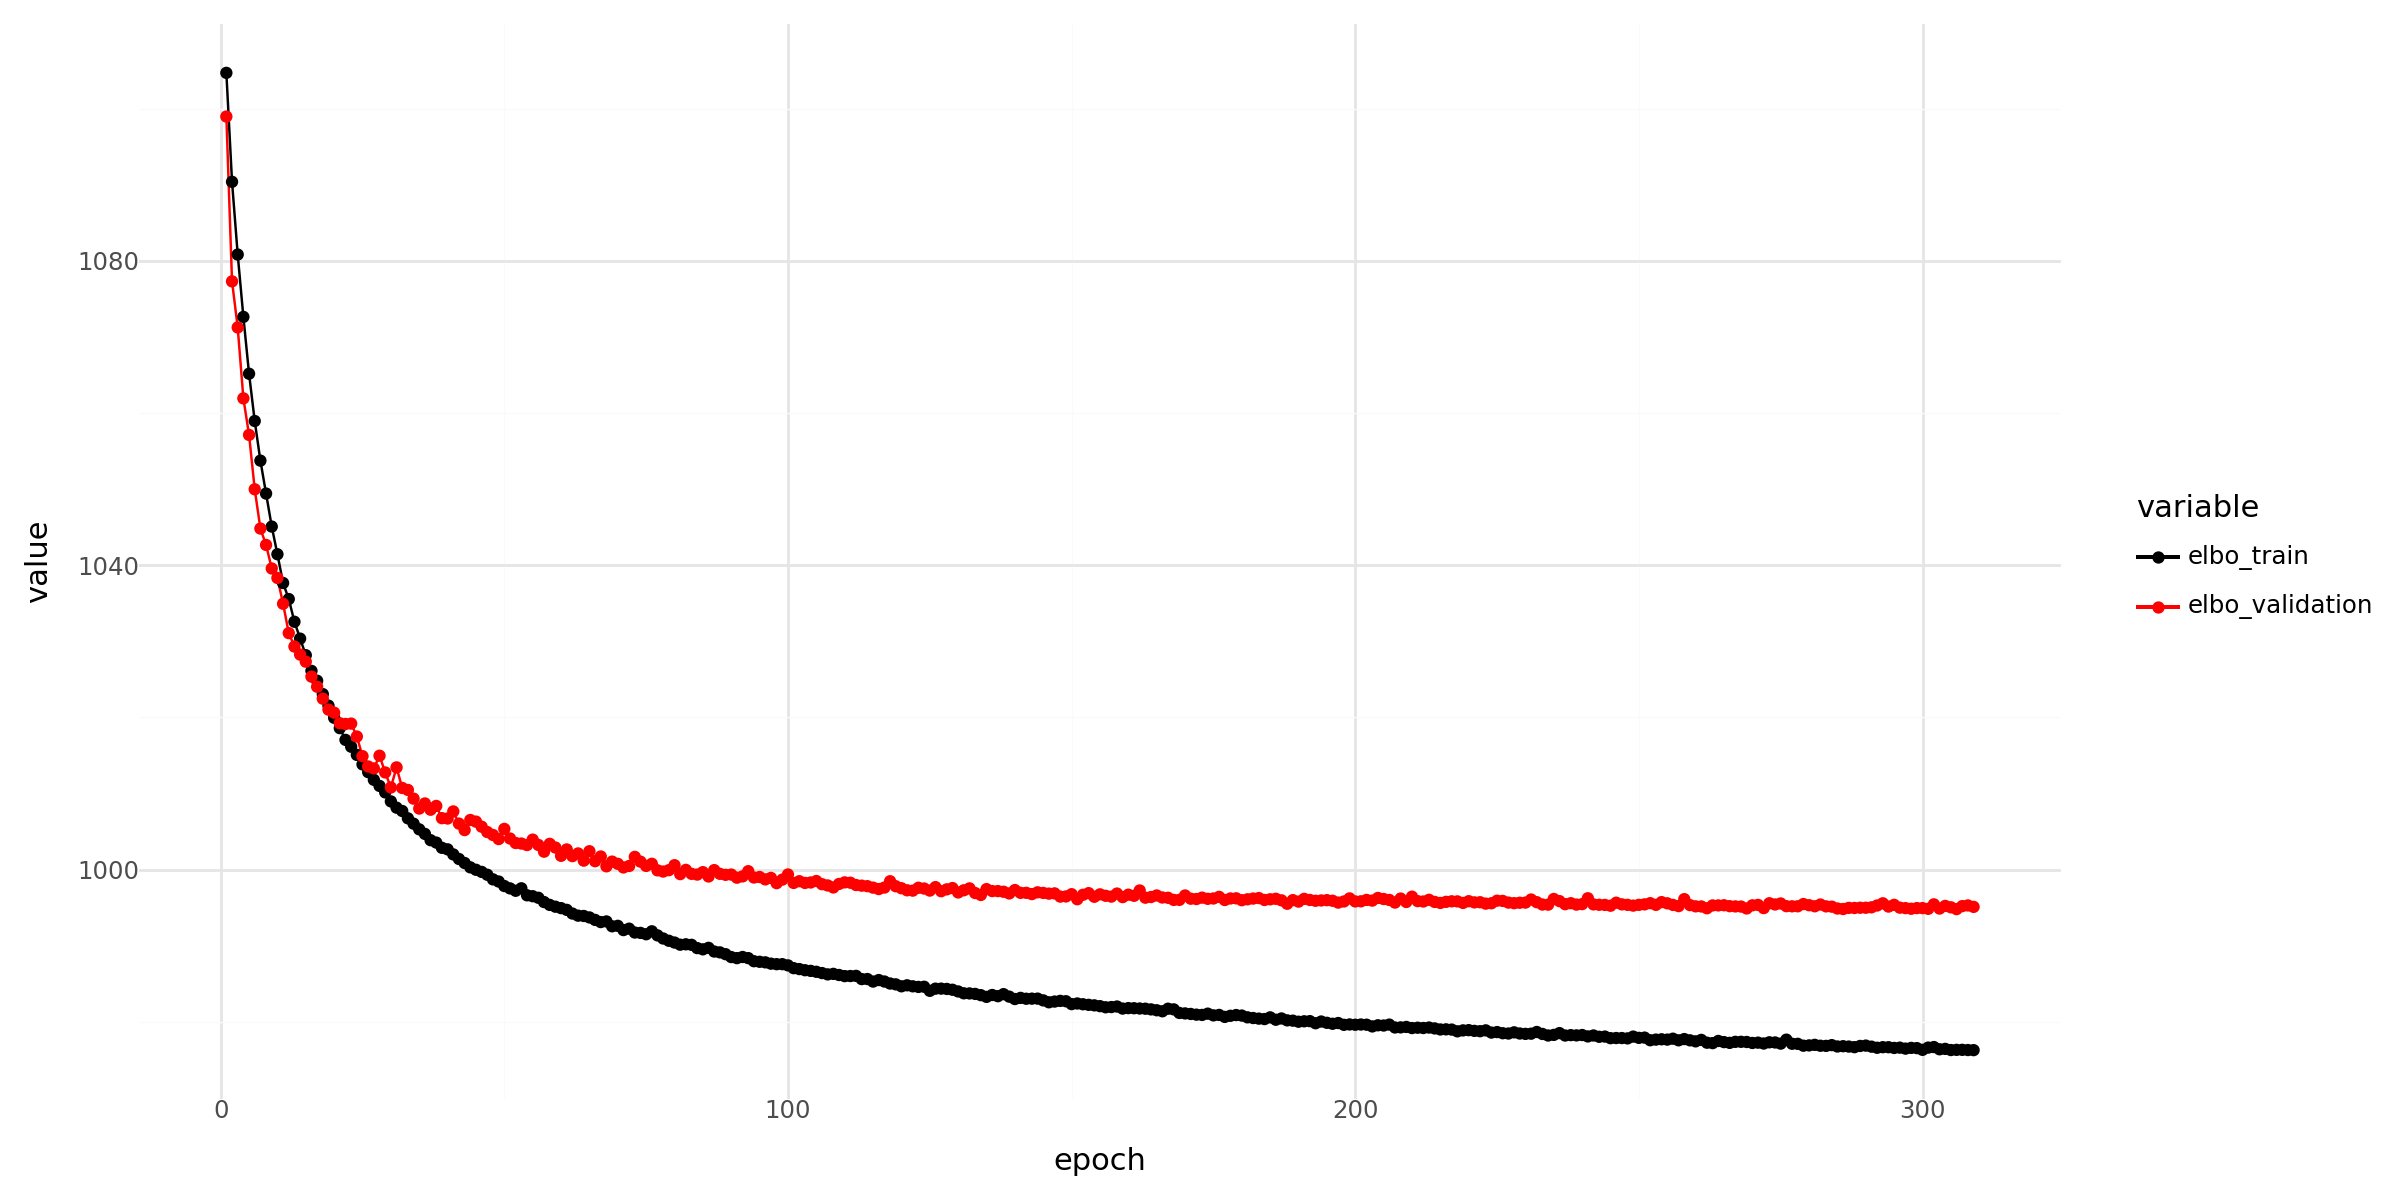

In [50]:
history_df = (
    model_scvi.history['elbo_train'].astype(float)
    .join(model_scvi.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('./scvi_la_sevensson.png', dpi = 300)

print(p_)

In [51]:
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [52]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
adata

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


AnnData object with n_obs × n_vars = 25768 × 5226
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'mt-query', 'ribo-query', 'n_cells_by_counts

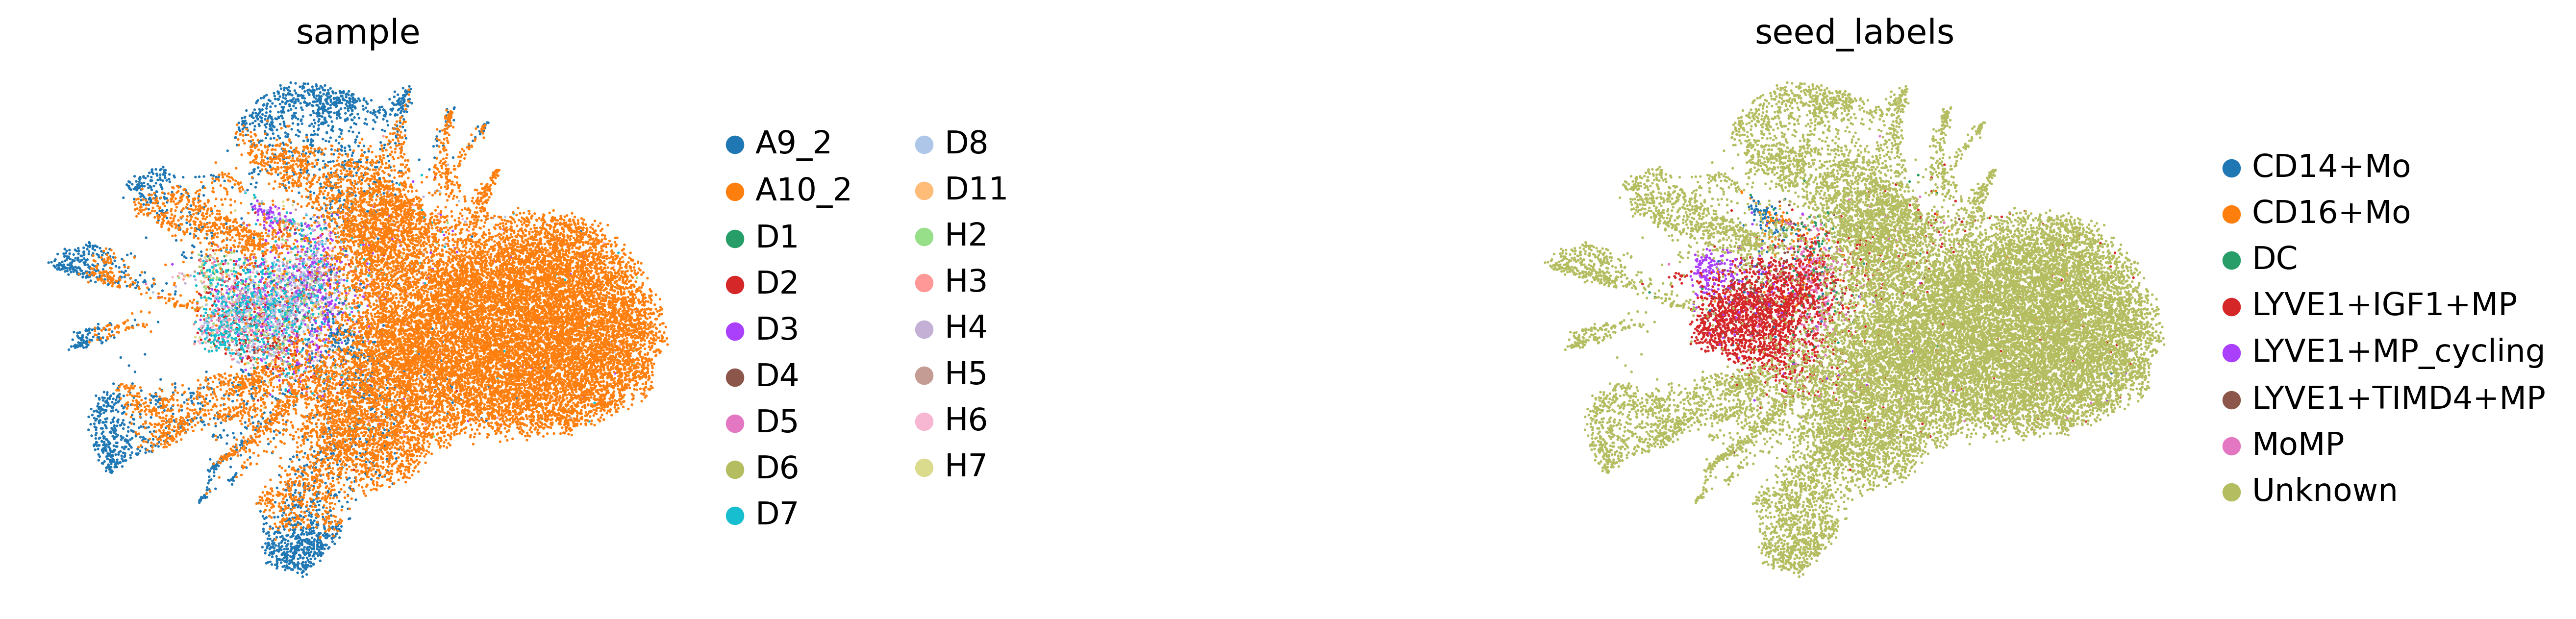

In [53]:
sc.pl.umap(adata, color=['sample', 'seed_labels'], wspace=1, frameon = False)

# scANVI

In [54]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(model_scvi,'Unknown')

In [55]:
model_scanvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.5.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'seed_labels',
│   'unlabeled_category': 'Unknown',
│   'layer': 'raw_counts',
│   'batch_key': 'sample',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample', 'batch'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  17   │
│         n_cells          │ 25768 │
│ n_extra_categorical_covs │   2   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   8   │
│          n_vars          │ 5226  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │         adata.layers['raw_counts']         │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    A9_2    │          0          │
│                     │   A10_2    │          1          │
│                     │     D1     │          2          │
│                     │     D2     │          3          │
│                     │     D3     │          4          │
│                     │     D4     │          5          │
│                     │     D5     │          6          │
│                     │     D6     │          7          │
│                     │     D7     │          8          │
│                     │     D8     │          9          │
│                     │    D11     │         10          │
│                     │     H2     │         11          │
│                     │     H3     │         12          │
│                     │     H4     │         13          │
│                     │     H5     │         14          │
│                     │     H6     │         15          │
│                     │     H7     │         16          │
└─────────────────────┴────────────┴─────────────────────┘

                        labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['seed_labels'] │     CD14+Mo      │          0          │
│                          │     CD16+Mo      │          1          │
│                          │        DC        │          2          │
│                          │  LYVE1+IGF1+MP   │          3          │
│                          │ LYVE1+MP_cycling │          4          │
│                          │  LYVE1+TIMD4+MP  │          5          │
│                          │       MoMP       │          6          │
│                          │     Unknown      │          7          │
└──────────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch']  │ reference  │          0          │
│                     │   query    │          1          │
│                     │            │                     │
│ adata.obs['sample'] │    A9_2    │          0          │
│                     │   A10_2    │          1          │
│                     │     D1     │          2          │
│                     │     D2     │          3          │
│                     │     D3     │          4          │
│                     │     D4     │          5          │
│                     │     D5     │          6          │
│                     │     D6     │          7          │
│                     │     D7     │          8          │
│                     │     D8     │          9          │
│                     │    D11     │         10          │
│                     │     H2     │         11          │
│                     │     H3     │         12          │
│                     │     H4     │         13          │
│                     │     H5     │         14          │
│                     │     H6     │         15          │
│                     │     H7     │         16          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [56]:
model_scanvi.train(max_epochs= 80, devices= [1], accelerator= 'gpu',check_val_every_n_epoch = 1, enable_progress_bar = True, )

INFO     Training for 80 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 80/80: 100%|██████████| 80/80 [03:56<00:00,  2.63s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=963]  

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80/80: 100%|██████████| 80/80 [03:56<00:00,  2.96s/it, v_num=1, train_loss_step=1.02e+3, train_loss_epoch=963]


In [57]:
model_scanvi.save('./', overwrite=True, prefix= 'scanvi')

In [58]:
adata.obsm["X_scANVI"] = model_scanvi.get_latent_representation()

## Evaluate model performance a la Svensson

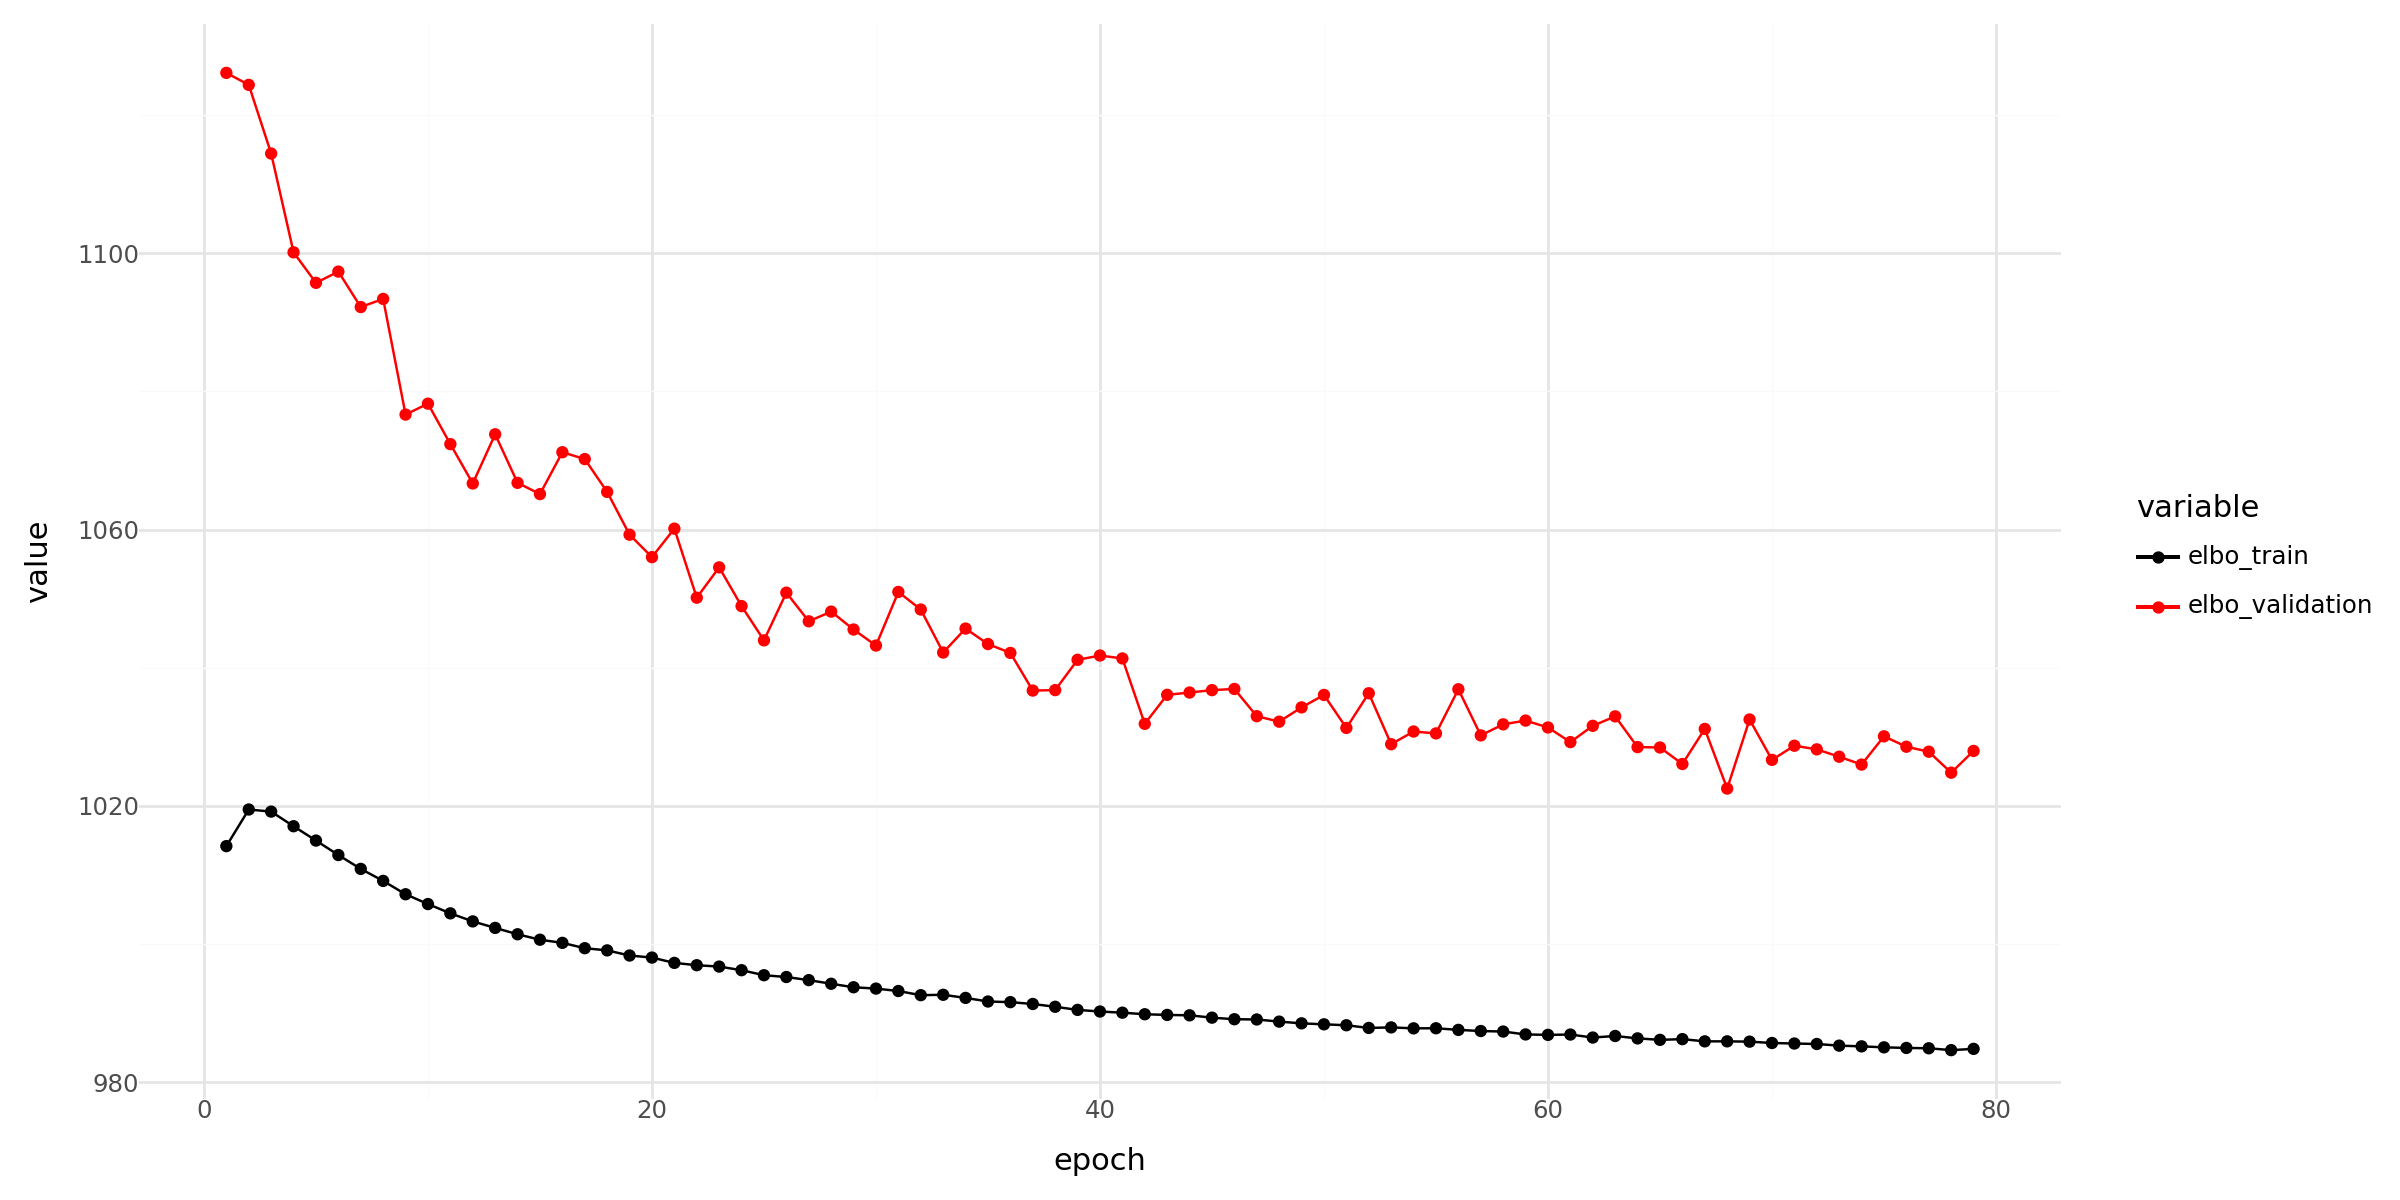

In [59]:
history_df = (
    model_scanvi.history['elbo_train'].astype(float)
    .join(model_scanvi.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scanvi_la_sevensson.png', dpi = 300)

print(p_)

In [60]:
adata.obs["C_scANVI"] = model_scanvi.predict(adata)

In [61]:
adata.obsm["X_scANVI"] = model_scanvi.get_latent_representation(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


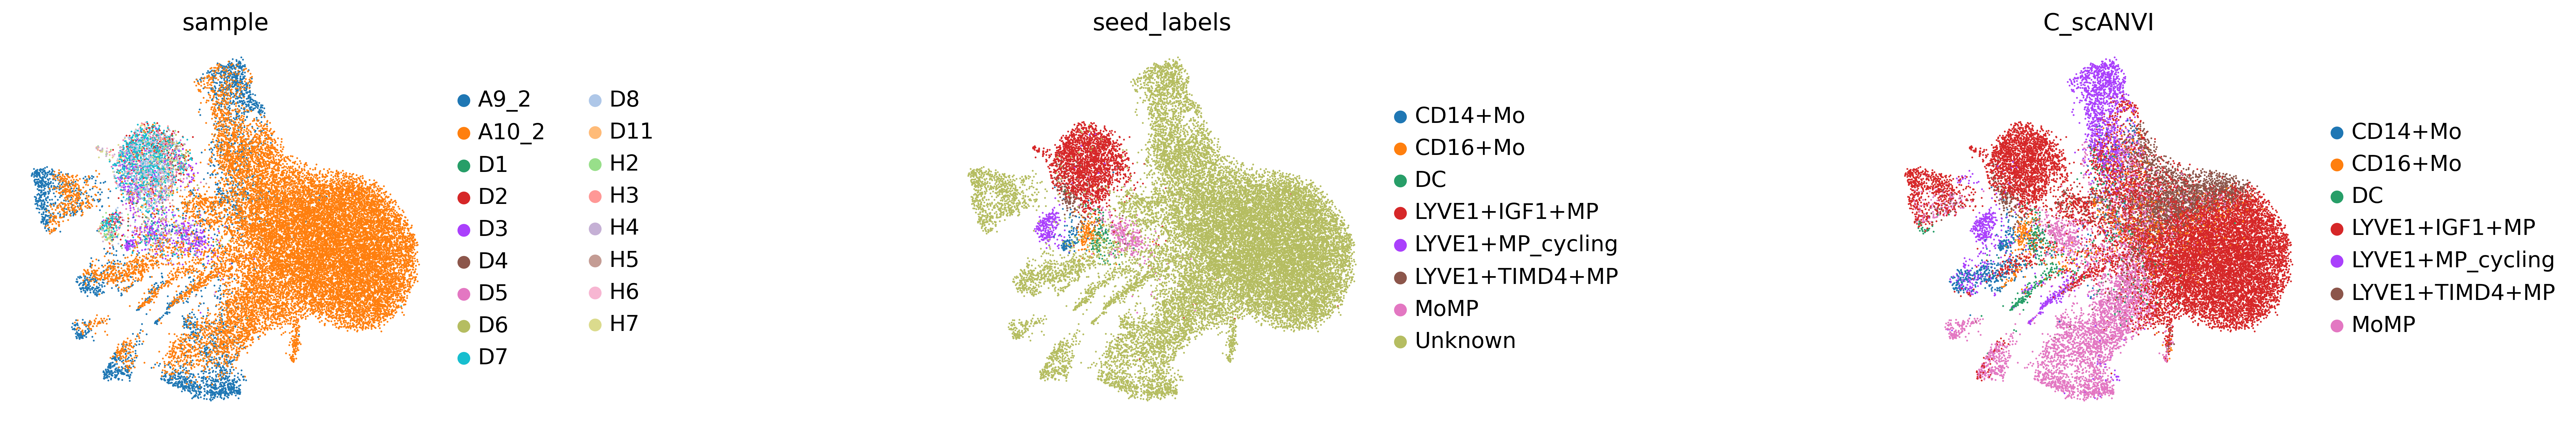

In [62]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['sample', 'seed_labels',"C_scANVI"], wspace=1, frameon = False)

# Export data

In [63]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 25768 × 5226
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cel

In [64]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 22527 × 5226
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query'

In [65]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 22527 × 8000
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts

In [66]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Sox17', 'Rgs20', 'Alkal1', 'St18',
       'Sntg1', '2610203c22rik',
       ...
       'Mt-co3', 'Mt-nd3', 'Mt-nd4l', 'Mt-nd4', 'Mt-nd5', 'Mt-nd6', 'Mt-cytb',
       'Tmlhe', 'Gm10931', 'Ac149090.1'],
      dtype='object', length=8000)

In [67]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
LYVE1+IGF1+MP       12548
MoMP                 4240
LYVE1+TIMD4+MP       2500
LYVE1+MP_cycling     1689
CD16+Mo               654
CD14+Mo               481
DC                    415
Name: count, dtype: int64

In [68]:
query_export.obs['cell_type'] = query_export.obs['C_scANVI'].copy()
#query_export.obs['cell_type'] = query_export.obs['cell_type'].replace('FB4_activated', 'FB4')
query_export

AnnData object with n_obs × n_vars = 22527 × 8000
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt', 'ribo', 'n_cells_by_counts

In [69]:
query_export.obs['cell_type'].value_counts()

cell_type
LYVE1+IGF1+MP       12548
MoMP                 4240
LYVE1+TIMD4+MP       2500
LYVE1+MP_cycling     1689
CD16+Mo               654
CD14+Mo               481
DC                    415
Name: count, dtype: int64

In [70]:
print(X_is_raw(query_export))

True


In [71]:
query_export.layers['raw_counts'] = query_export.X

In [72]:
sc.pp.normalize_total(query_export, target_sum= 1e6)
sc.pp.log1p(query_export)
query_export.layers['normalized'] = query_export.X

normalizing counts per cell
    finished (0:00:00)


computing PCA
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


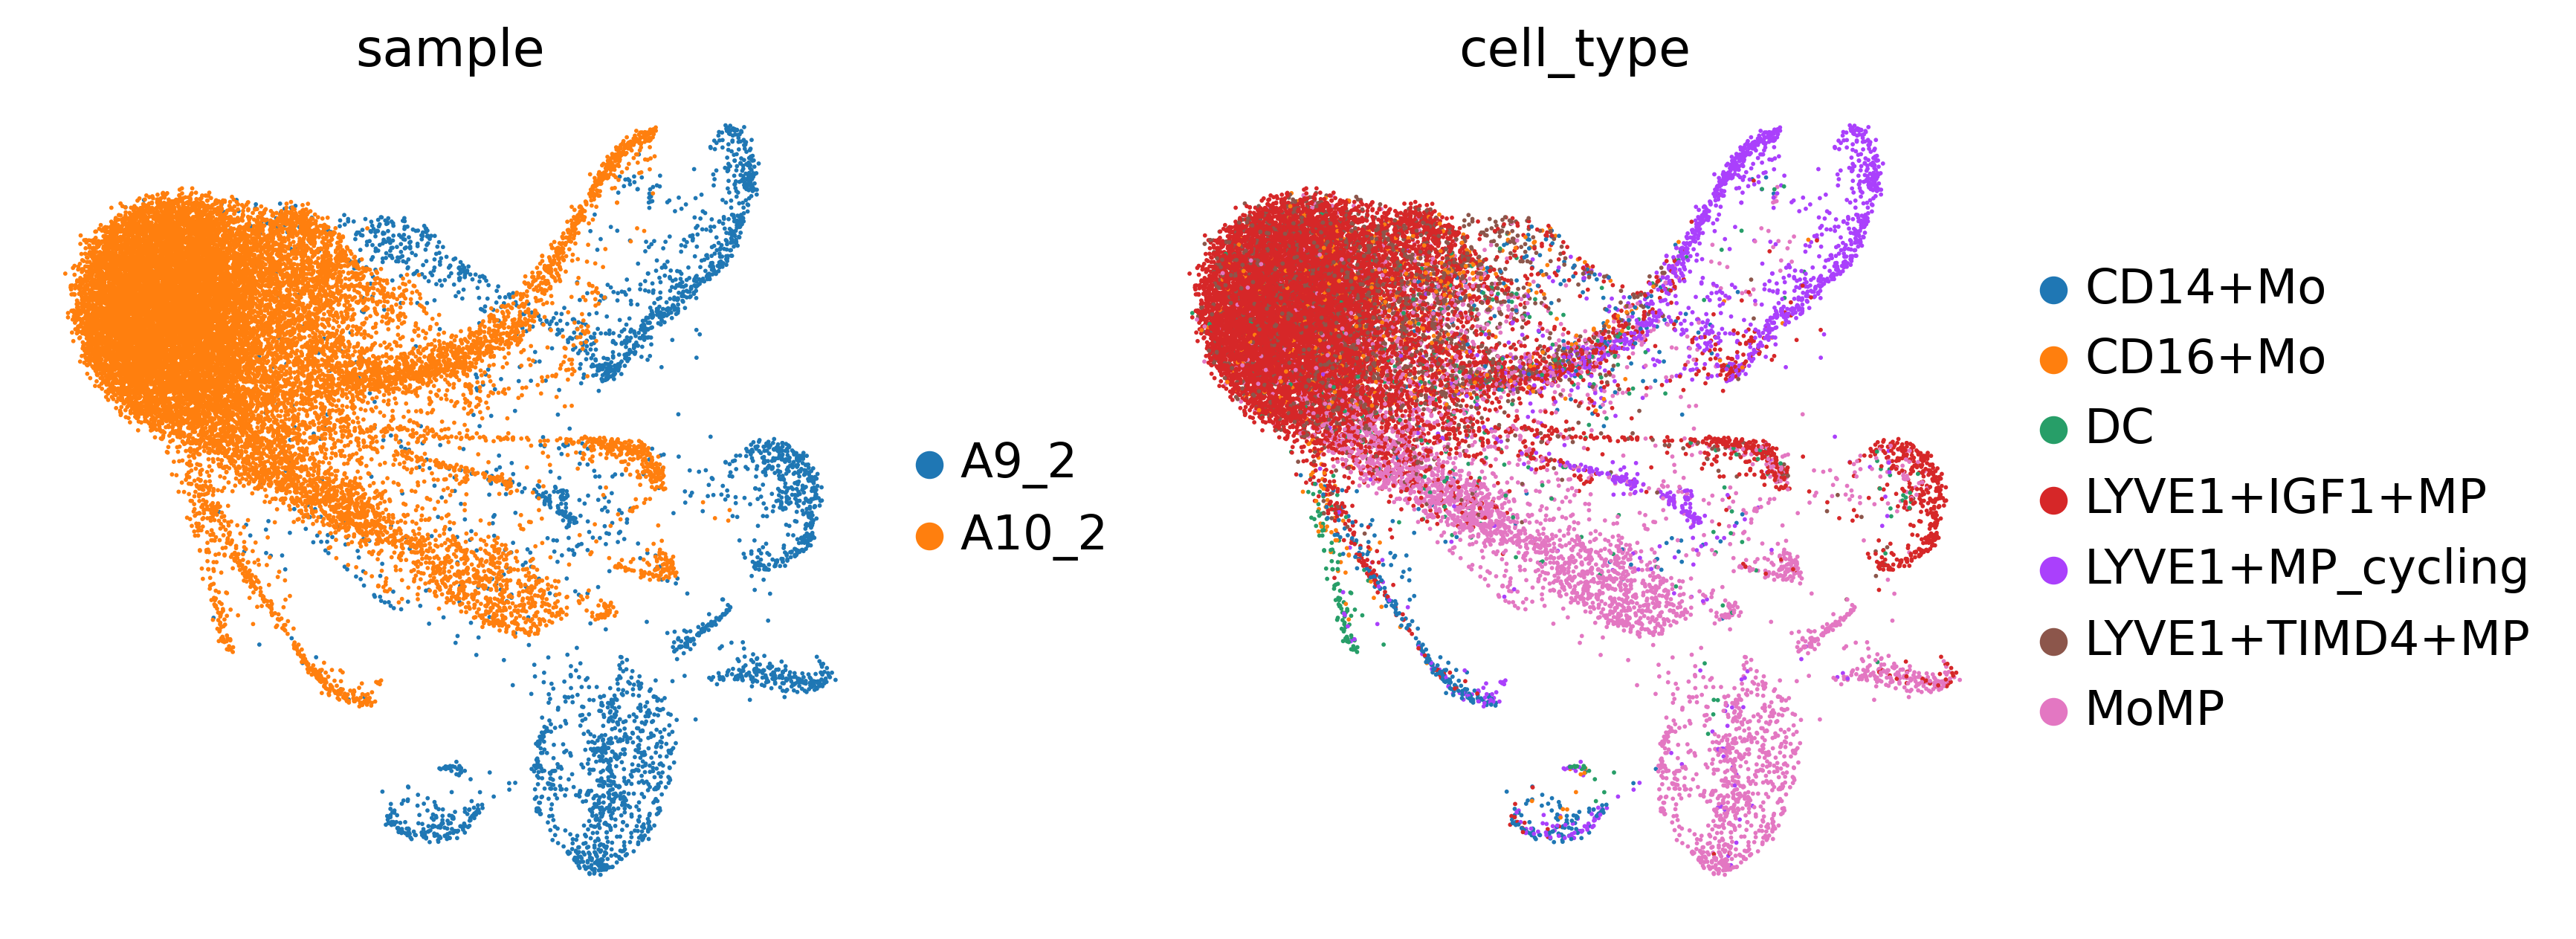

In [73]:
sc.pp.pca(query_export)
sc.pp.neighbors(query_export)
sc.tl.umap(query_export)
sc.pl.umap(query_export, color = ['sample', 'cell_type'], frameon= False)

In [74]:
query_export.write(f'../../data/dmd_annotated_myeloid_{timestamp}.h5ad')

# SCIB metrics

In [75]:
adata

AnnData object with n_obs × n_vars = 25768 × 5226
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    var: 'mt-query', 'ribo-query', 'n_cel

In [76]:
scib = scib_metrics.benchmark.Benchmarker(adata, batch_key = 'sample', label_key = 'seed_labels', embedding_obsm_keys = ['X_scVI', 'X_scANVI'])

In [77]:
scib.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:02)


Embeddings: 100%|██████████| 2/2 [01:21<00:00, 40.78s/it]


In [78]:
scib.get_results()

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
X_scVI                    1.0               0.0               0.0   
X_scANVI                  0.0               1.0               1.0   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
X_scVI                    0.0               0.0               1.0   
X_scANVI                  1.0               1.0               0.0   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
X_scVI                    1.0               0.0                0.0   
X_scANVI                  0.0               1.0                1.0   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
X_scVI                    1.0              0.6              0.2   
X_scANVI                  0.0              0.4              0.8   
Metric Type  Batch correction  Aggregate score  Aggregate score   

                       Total  
Embedding                     
X_scVI                  0.36  
X_scANVI                0.64  
Metric Type  Aggregate score

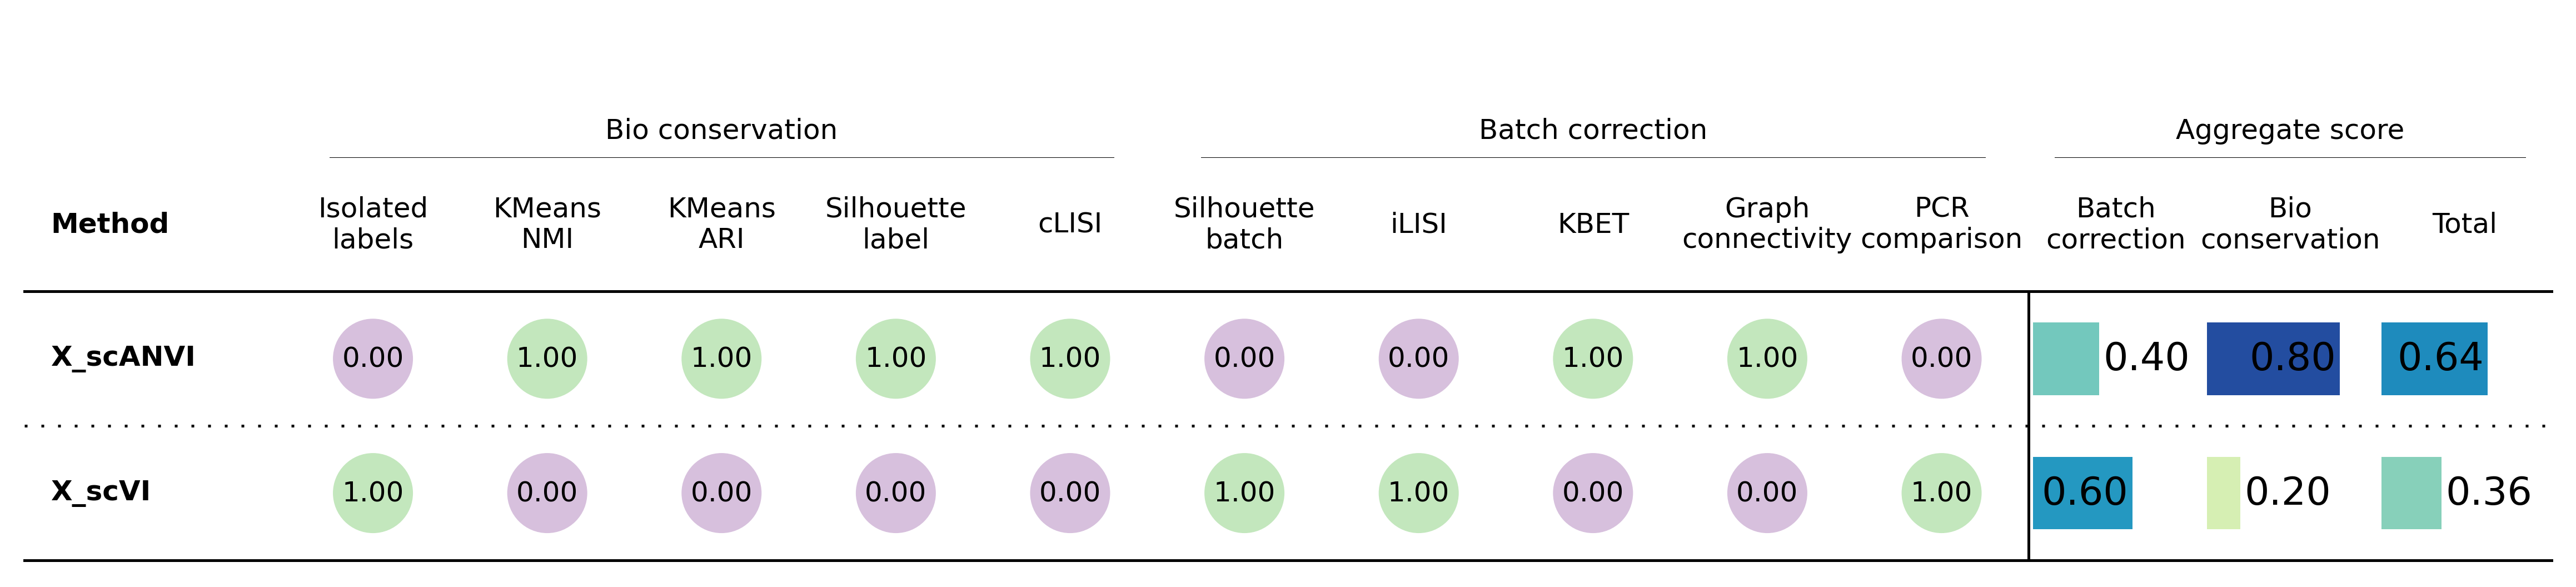

In [79]:
scib.plot_results_table()